#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
!pip install pandas
!pip install tensorflow
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [2]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"



Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [3]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [6]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [7]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

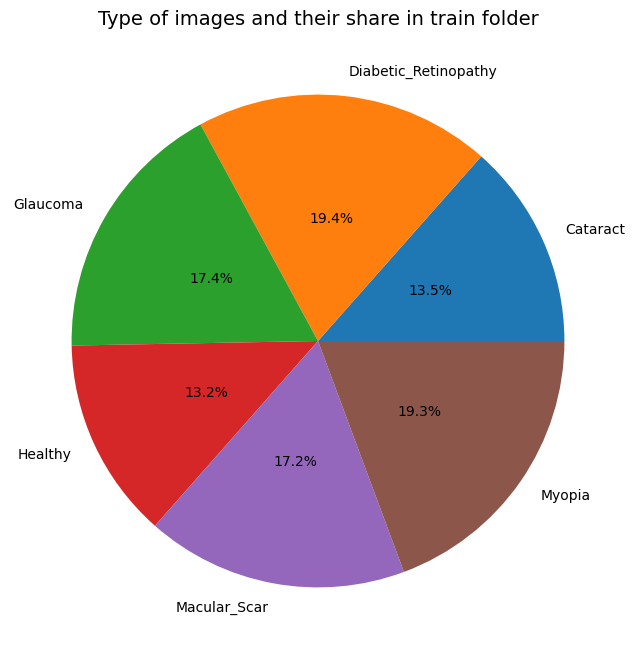

In [8]:
plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images), len(glaucoma_images),
                    len(healthy_images), len(macular_scar_images),len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma",
                                                  "Healthy", "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Visualizamos algunas de las imagenes del dataset

In [9]:
def show_6_images(vector_imagenes, filtro, titulo):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
      img = cv2.imread(vector_imagenes[i])
      img = cv2.resize(img, (220,220))
      if (filtro =="Canny"):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.Canny(img, 80, 100)
      ax.imshow(img)
      ax.set_title(titulo)
  fig.tight_layout()
  plt.show()

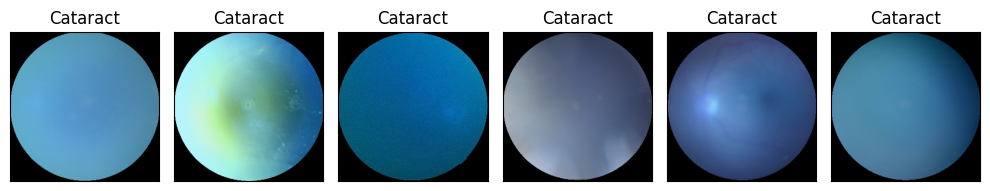

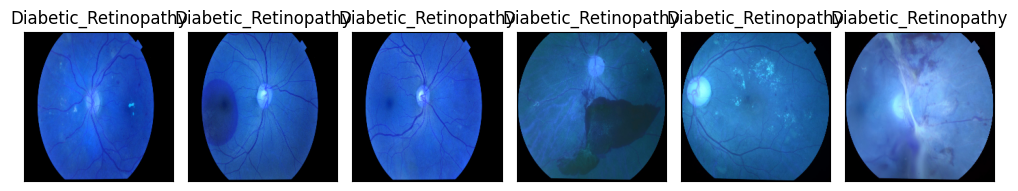

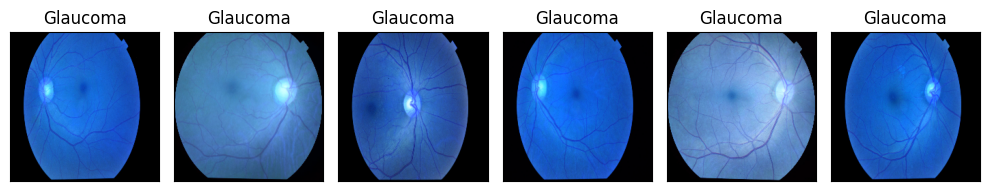

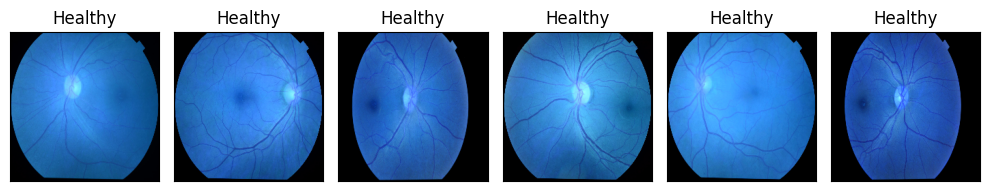

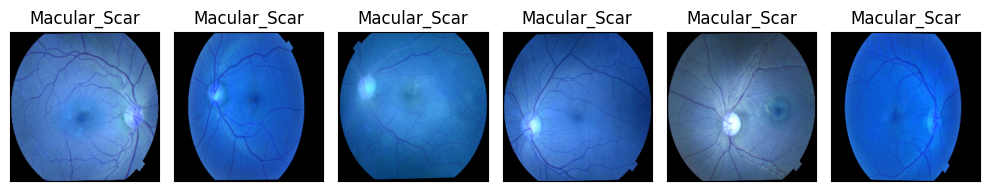

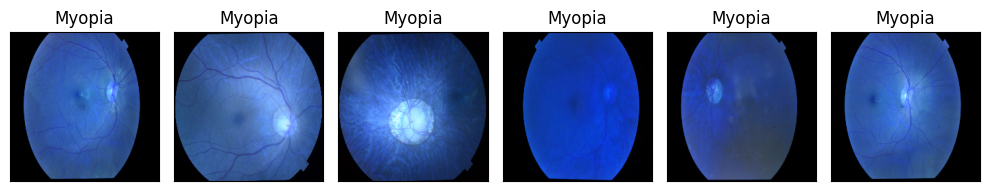

In [10]:
show_6_images(cataract_images, "", "Cataract")
show_6_images(diabetic_retinopathy_images, "", "Diabetic_Retinopathy")
show_6_images(glaucoma_images, "", "Glaucoma")
show_6_images(healthy_images, "", "Healthy")
show_6_images(macular_scar_images, "", "Macular_Scar")
show_6_images(myopia_images, "", "Myopia")


## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [14]:
input_shape = (224, 224, 3)

## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [15]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(15,15))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(15,15))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [17]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [18]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
base_model1 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model1.layers:
    layer.trainable = False


model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 23827846 (90.90 MB)
Trainable params: 26304

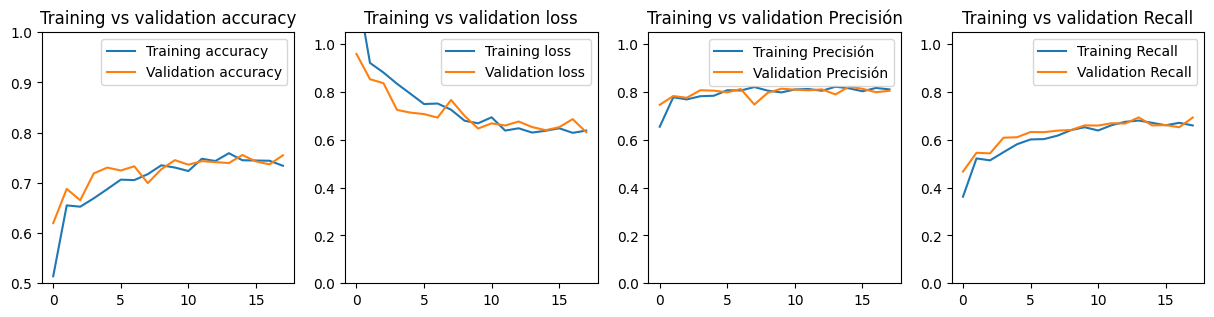

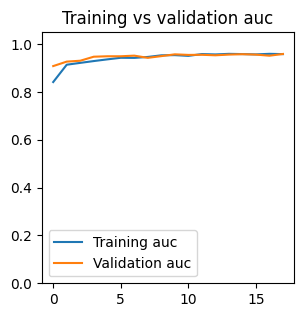

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 15s 390ms/step


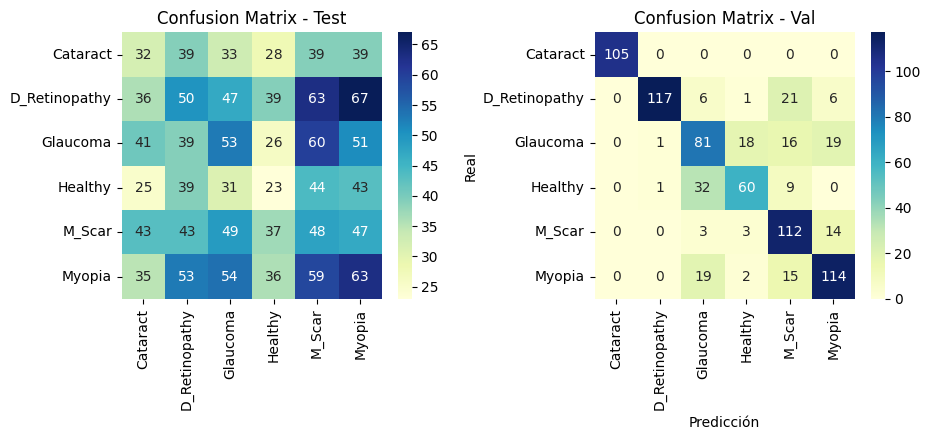

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.19      0.17      0.18       302
           2       0.20      0.20      0.20       270
           3       0.12      0.11      0.12       205
           4       0.15      0.18      0.17       267
           5       0.20      0.21      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.98      0.77      0.87       151
           2       0.57      0.60      0.59       135
           3       0.71      0.59      0.65       102
           4       0.65      0.85      0.73       132
           5       0.75      0.76      0.75       150

    accuracy                           0.76       775
   macro avg       0.78

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 24123014 (92.02 MB)
Trainable params: 55821

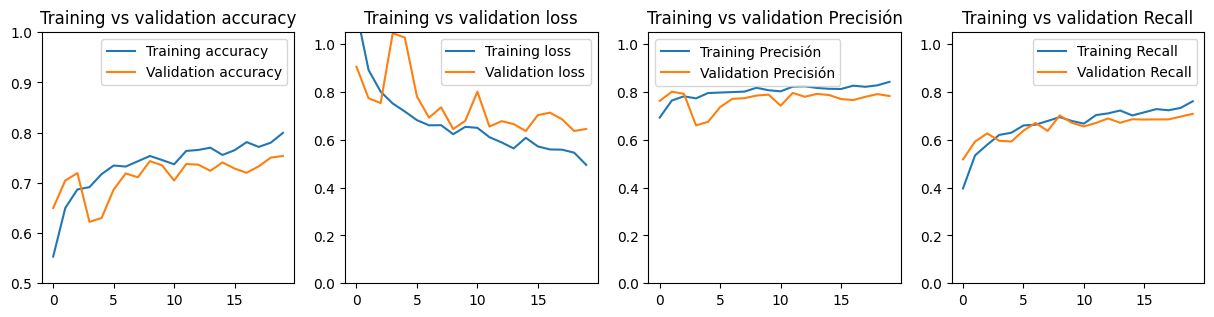

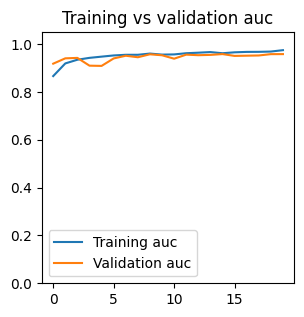

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 14s 375ms/step


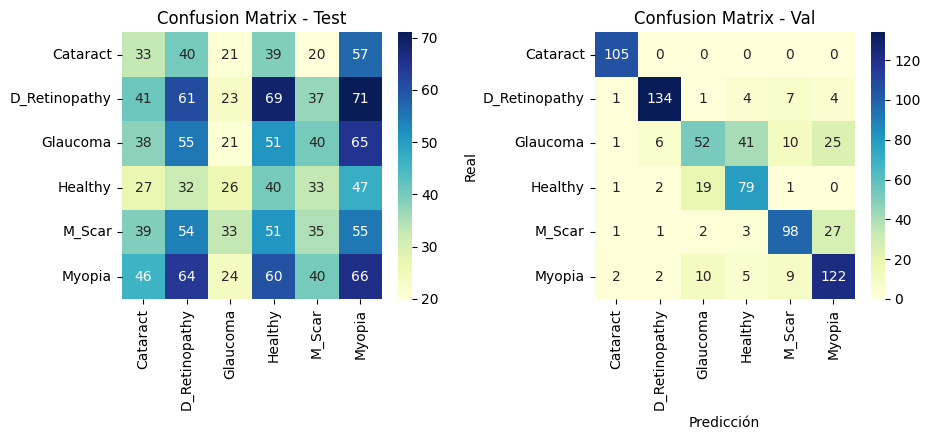

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.16      0.15       210
           1       0.20      0.20      0.20       302
           2       0.14      0.08      0.10       270
           3       0.13      0.20      0.16       205
           4       0.17      0.13      0.15       267
           5       0.18      0.22      0.20       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       105
           1       0.92      0.89      0.91       151
           2       0.62      0.39      0.47       135
           3       0.60      0.77      0.68       102
           4       0.78      0.74      0.76       132
           5       0.69      0.81      0.74       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 5

In [ ]:
base_model5 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model5.layers:
    layer.trainable = False


model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_4 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

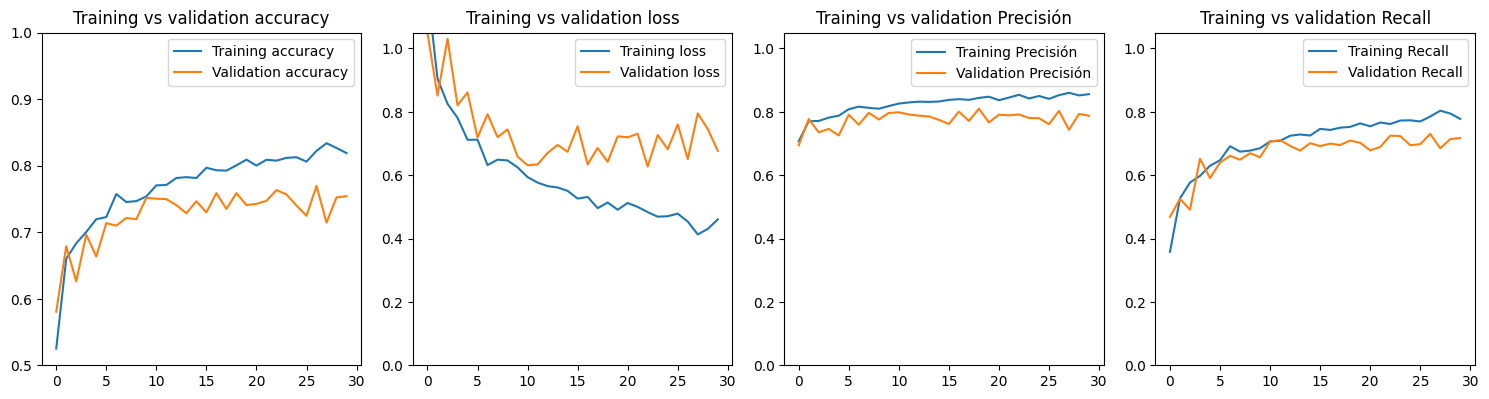

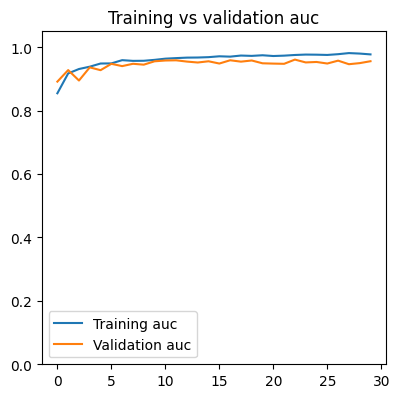

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 13s 330ms/step


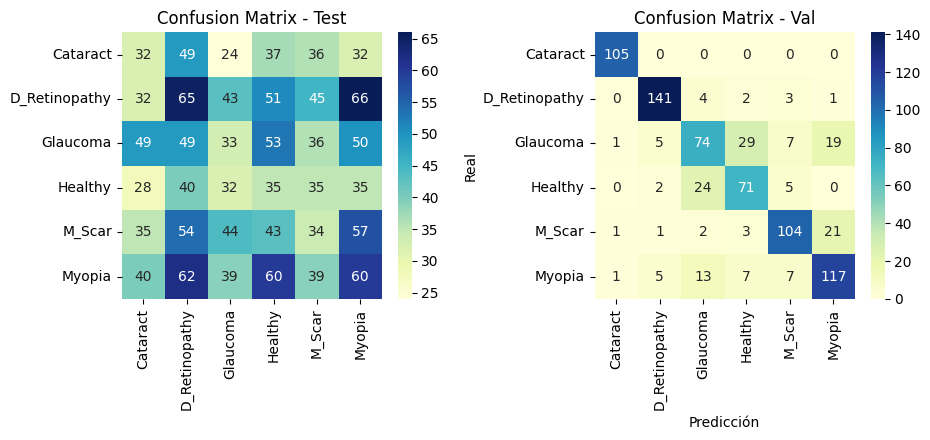

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.20      0.22      0.21       302
           2       0.15      0.12      0.14       270
           3       0.13      0.17      0.14       205
           4       0.15      0.13      0.14       267
           5       0.20      0.20      0.20       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.92      0.93      0.92       151
           2       0.63      0.55      0.59       135
           3       0.63      0.70      0.66       102
           4       0.83      0.79      0.81       132
           5       0.74      0.78      0.76       150

    accuracy                           0.79       775
   macro avg       0.79

## Modelo 15

In [ ]:
base_model15 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model15.layers:
    layer.trainable = False


model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_9 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                      

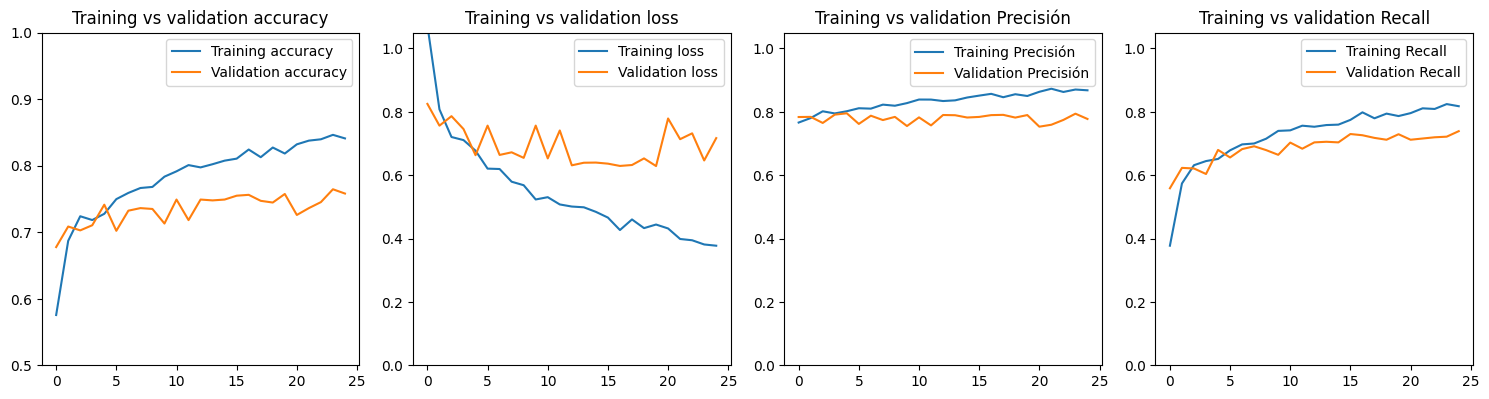

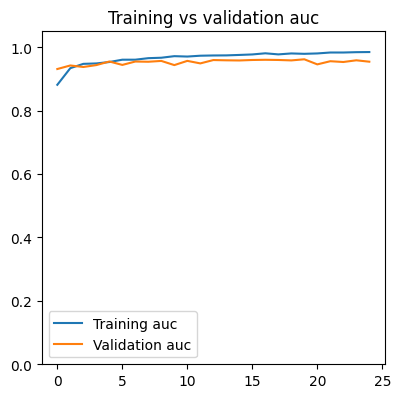

In [ ]:
graph(history15)

39/39 [==============================] - 12s 308ms/step


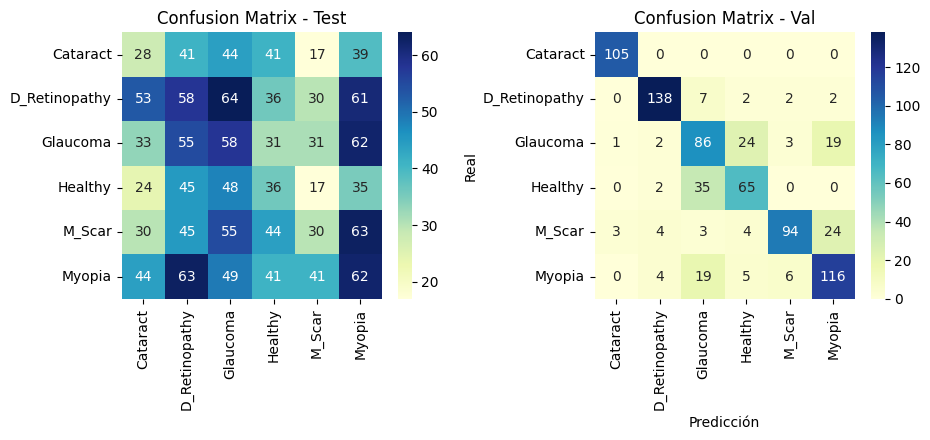

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.19      0.19       302
           2       0.18      0.21      0.20       270
           3       0.16      0.18      0.17       205
           4       0.18      0.11      0.14       267
           5       0.19      0.21      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       105
           1       0.92      0.91      0.92       151
           2       0.57      0.64      0.60       135
           3       0.65      0.64      0.64       102
           4       0.90      0.71      0.79       132
           5       0.72      0.77      0.75       150

    accuracy                           0.78       775
   macro avg       0.79

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 2056)              4212744   
                                                                 
 dropout_1 (Dropout)         (None, 2056)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                      

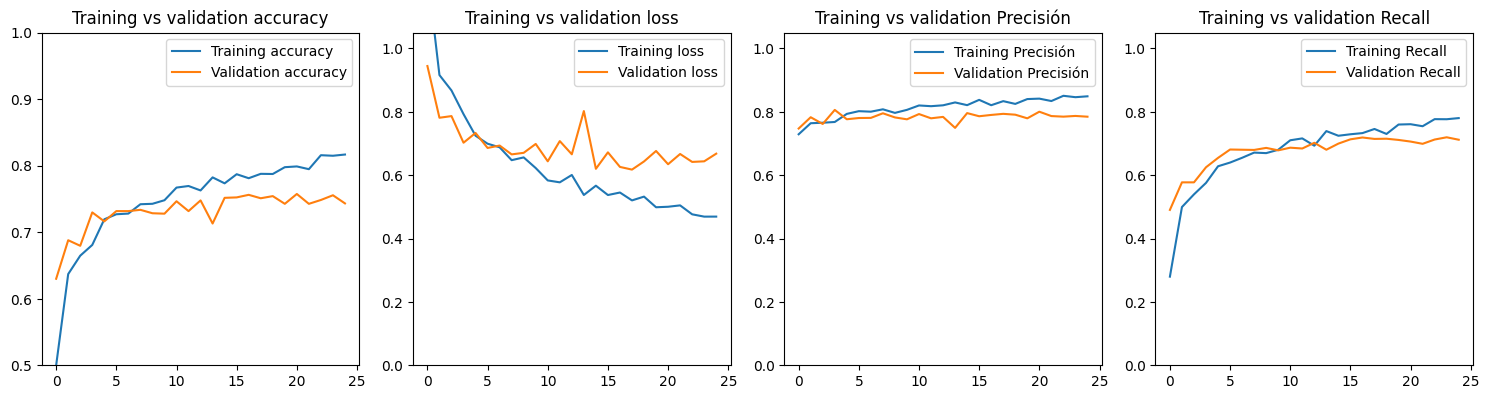

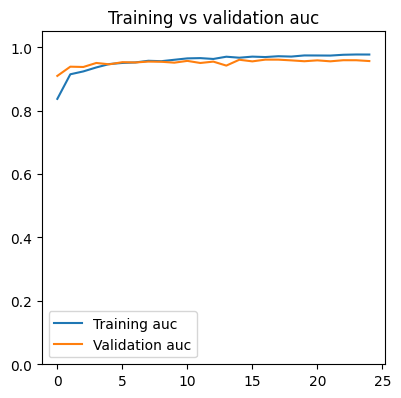

In [ ]:
graph(history16)

39/39 [==============================] - 15s 384ms/step


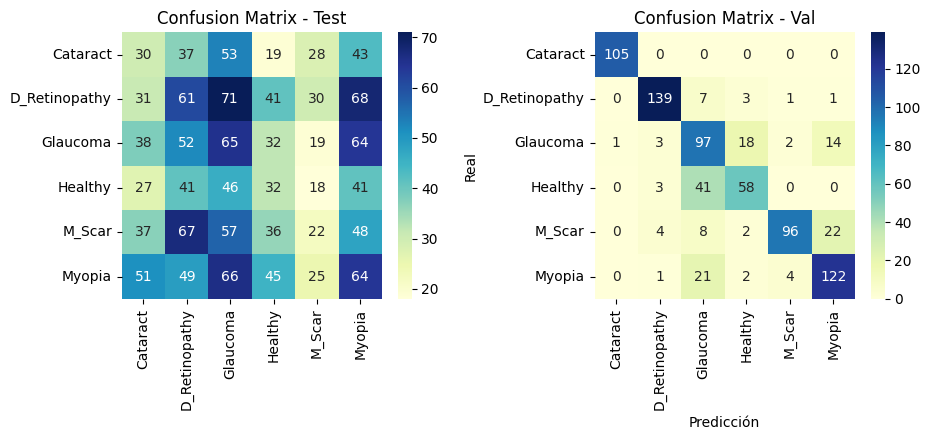

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.20      0.20      0.20       302
           2       0.18      0.24      0.21       270
           3       0.16      0.16      0.16       205
           4       0.15      0.08      0.11       267
           5       0.20      0.21      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.93      0.92      0.92       151
           2       0.56      0.72      0.63       135
           3       0.70      0.57      0.63       102
           4       0.93      0.73      0.82       132
           5       0.77      0.81      0.79       150

    accuracy                           0.80       775
   macro avg       0.81

## Modelo 6

In [ ]:
base_model6 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5112)              10474488  
                                                                 
 dense_1 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_2 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_3 (Dense)             (None, 512)               52

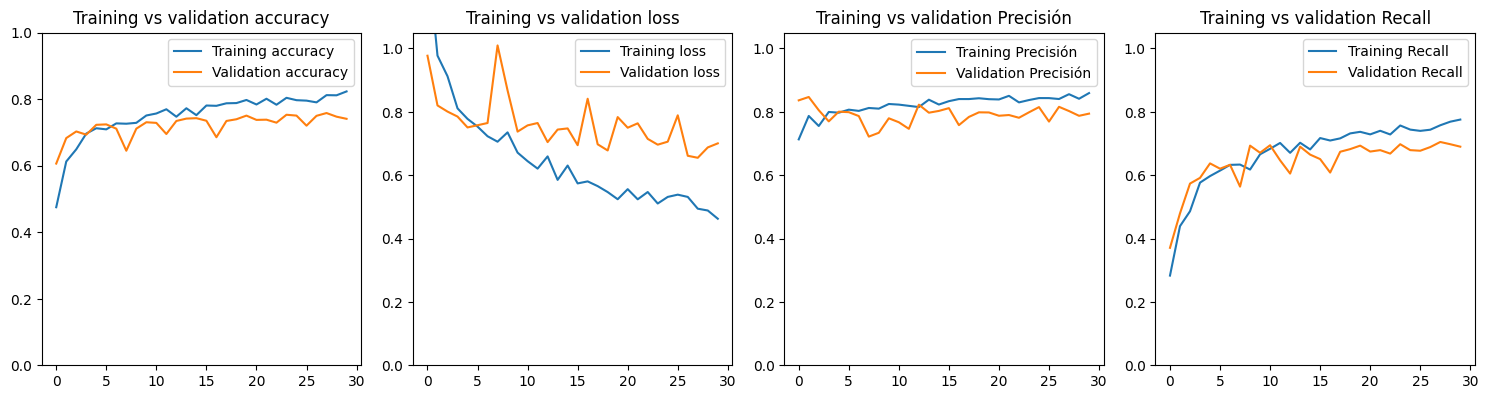

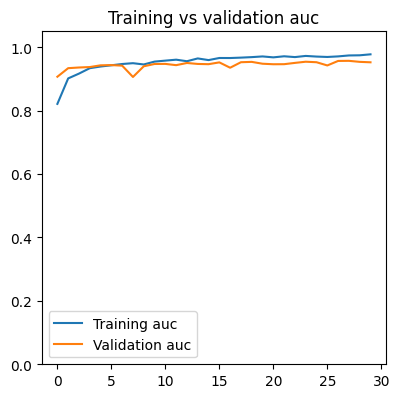

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 15s 397ms/step


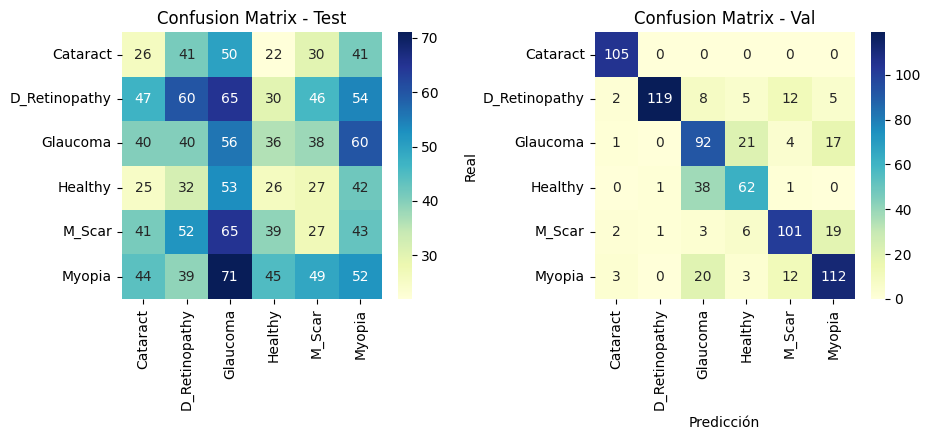

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.23      0.20      0.21       302
           2       0.16      0.21      0.18       270
           3       0.13      0.13      0.13       205
           4       0.12      0.10      0.11       267
           5       0.18      0.17      0.18       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       105
           1       0.98      0.79      0.88       151
           2       0.57      0.68      0.62       135
           3       0.64      0.61      0.62       102
           4       0.78      0.77      0.77       132
           5       0.73      0.75      0.74       150

    accuracy                           0.76       775
   macro avg       0.77

## Modelo 3

In [ ]:
base_model3 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model3.layers:
    layer.trainable = False


model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(2048, activation = 'relu'))
model3.add(Dense(4096, activation = 'sigmoid'))
model3.add(Dense(2048, activation = 'relu'))
model3.add(Dense(6, activation='softmax'))
model3.summary()

model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history3 = model3.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_9 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_10 (Dense)            (None, 6)                 12294     
                                                      

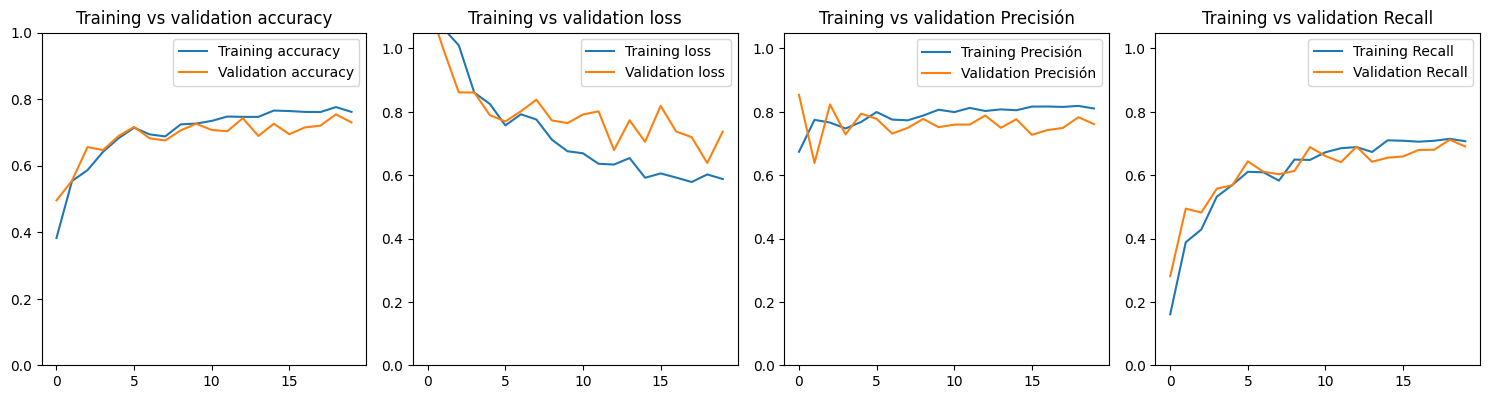

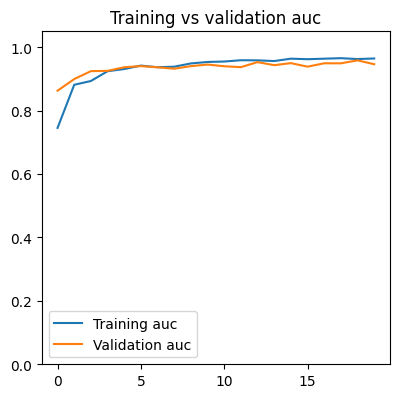

In [ ]:
graph(history3)

39/39 [==============================] - 16s 419ms/step


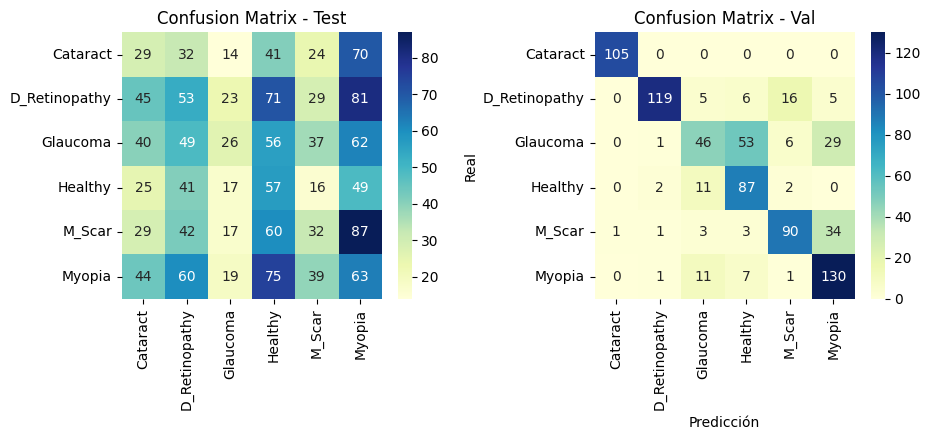

In [ ]:
y_pred3_test = model3.predict(test_generator)
y_pred3_val = model3.predict(validation_generator)
cf_matrix(y_pred3_test, test_generator.classes, y_pred3_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model3, y_pred3_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model3, y_pred3_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.19      0.18      0.18       302
           2       0.22      0.10      0.13       270
           3       0.16      0.28      0.20       205
           4       0.18      0.12      0.14       267
           5       0.15      0.21      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.18      0.17      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.96      0.79      0.87       151
           2       0.61      0.34      0.44       135
           3       0.56      0.85      0.67       102
           4       0.78      0.68      0.73       132
           5       0.66      0.87      0.75       150

    accuracy                           0.74       775
   macro avg       0.76

## Modelo 7

In [ ]:
base_model7 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model7.layers:
    layer.trainable = False


model7 = Sequential()
model7.add(base_model7)
model7.add(GlobalAveragePooling2D())
model7.add(Dense(2048, activation = 'relu'))
model7.add(Dropout(0.5))
model7.add(Dense(4096, activation = 'sigmoid'))
model7.add(Dropout(0.5))
model7.add(Dense(2048, activation = 'relu'))
model7.add(Dropout(0.25))
model7.add(Dense(6, activation='softmax'))
model7.summary()

model7.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history7 = model7.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                      

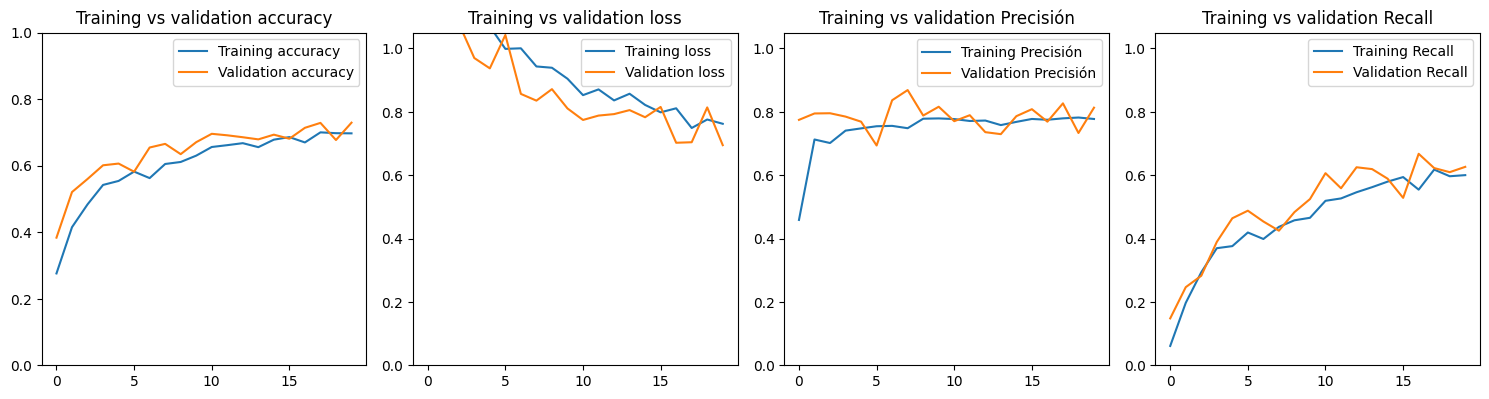

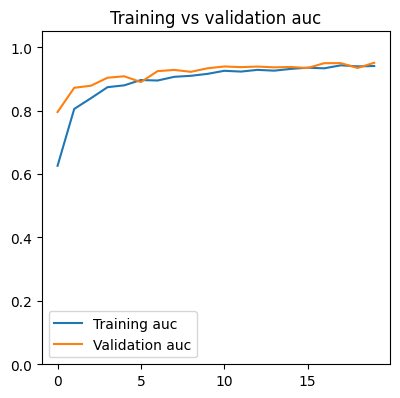

In [ ]:
graph(history7)

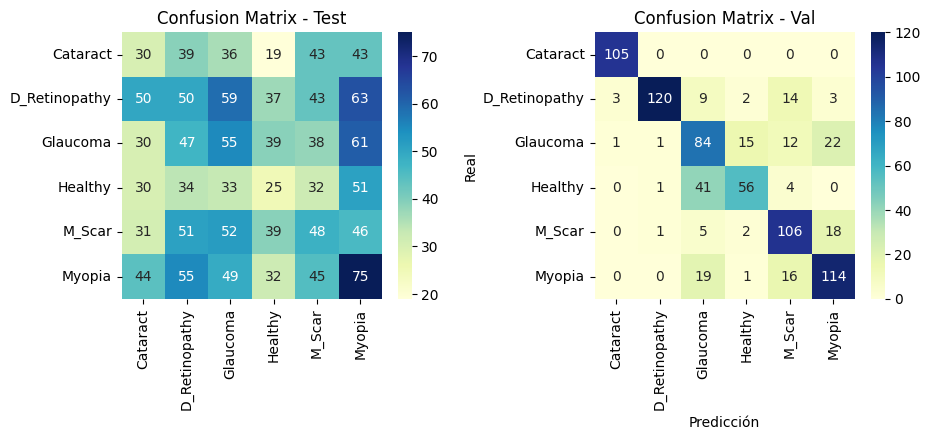

In [ ]:
y_pred7_test = model7.predict(test_generator)
y_pred7_val = model7.predict(validation_generator)
cf_matrix(y_pred7_test, test_generator.classes, y_pred7_val, validation_generator.classes)

In [ ]:
current_lr = model7.optimizer.learning_rate.numpy()
print("Current Learning Rate:", current_lr)

Current Learning Rate: 0.001


In [ ]:
reporte = calcular_metricas_por_clase(model7, y_pred7_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model7, y_pred7_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.18      0.17      0.17       302
           2       0.19      0.20      0.20       270
           3       0.13      0.12      0.13       205
           4       0.19      0.18      0.19       267
           5       0.22      0.25      0.23       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       105
           1       0.98      0.79      0.88       151
           2       0.53      0.62      0.57       135
           3       0.74      0.55      0.63       102
           4       0.70      0.80      0.75       132
           5       0.73      0.76      0.74       150

    accuracy                           0.75       775
   macro avg       0.77

## Modelo 8

In [ ]:
from tensorflow.keras.layers import GlobalMaxPool2D

base_model8 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model8.layers:
    layer.trainable = False


model8 = Sequential()
model8.add(base_model8)
model8.add(GlobalMaxPool2D())
model8.add(Dense(2048, activation = 'relu'))
model8.add(Dropout(0.5))
model8.add(Dense(4096, activation = 'sigmoid'))
model8.add(Dropout(0.5))
model8.add(Dense(2048, activation = 'relu'))
model8.add(Dropout(0.25))
model8.add(Dense(6, activation='softmax'))
model8.summary()

model8.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history8 = model8.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_15 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                      

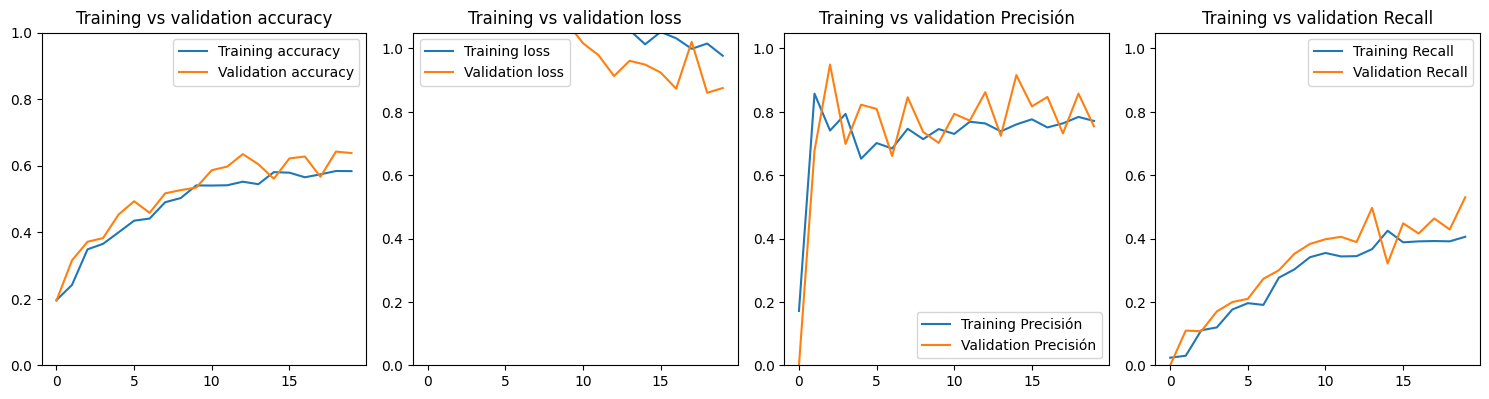

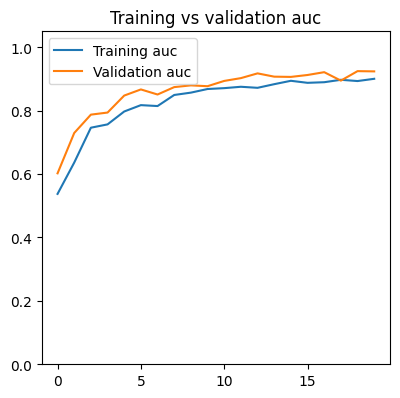

In [ ]:
graph(history8)

39/39 [==============================] - 16s 411ms/step


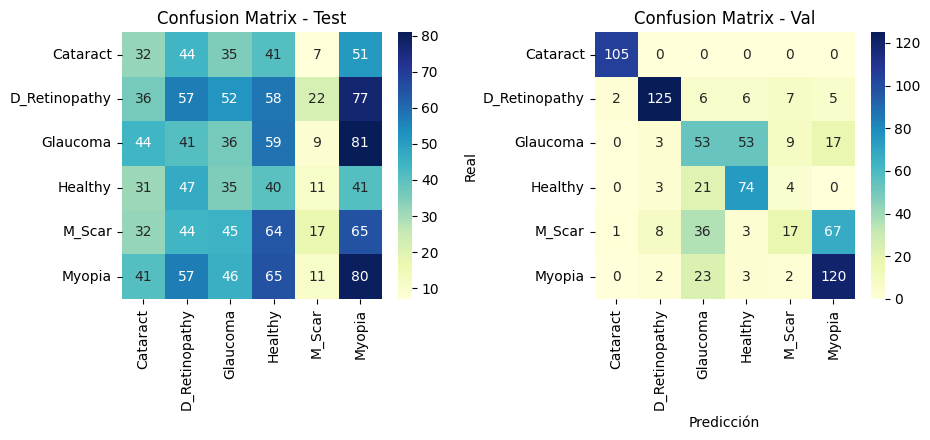

In [ ]:
y_pred8_test = model8.predict(test_generator)
y_pred8_val = model8.predict(validation_generator)
cf_matrix(y_pred8_test, test_generator.classes, y_pred8_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model8, y_pred8_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model8, y_pred8_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.20      0.19      0.19       302
           2       0.14      0.13      0.14       270
           3       0.12      0.20      0.15       205
           4       0.22      0.06      0.10       267
           5       0.20      0.27      0.23       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.18      0.17      0.16      1554

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       105
           1       0.89      0.83      0.86       151
           2       0.38      0.39      0.39       135
           3       0.53      0.73      0.61       102
           4       0.44      0.13      0.20       132
           5       0.57      0.80      0.67       150

    accuracy                           0.64       775
   macro avg       0.63

## Modelo 9

In [ ]:
base_model9 = tf.keras.applications.VGG19(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model9.layers:
    layer.trainable = False


model9 = Sequential()
model9.add(base_model9)
model9.add(GlobalAveragePooling2D())
model9.add(Dense(2048, activation = 'relu'))
model9.add(Dense(4096, activation = 'sigmoid'))
model9.add(Dense(2048, activation = 'relu'))
model9.add(Dense(6, activation='softmax'))
model9.summary()

model9.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history9 = model9.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_20 (Dense)            (None, 4096)              8392704   
                                                                 
 dense_21 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_22 (Dense)            (None, 6)                 

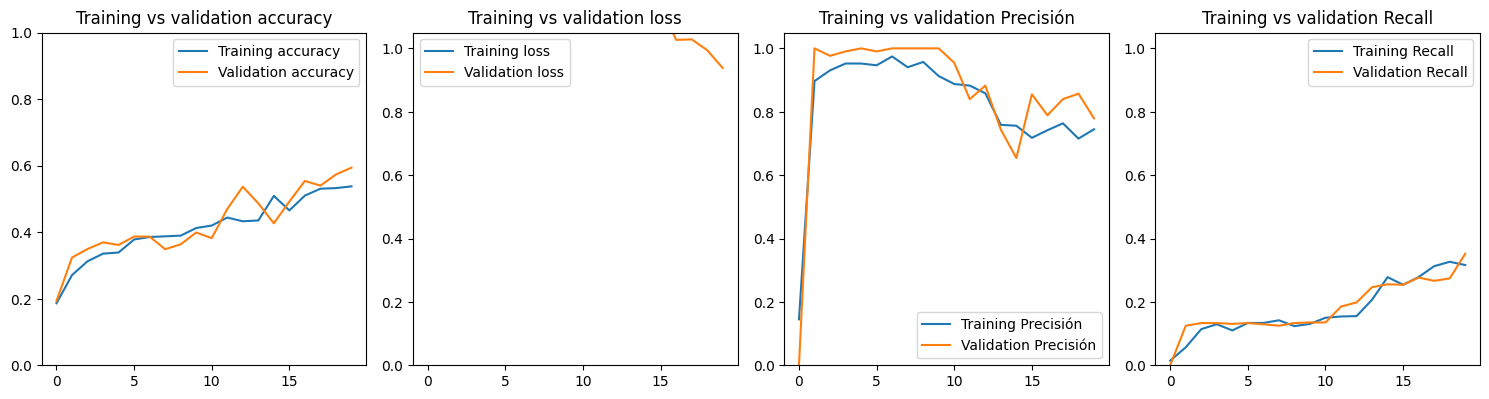

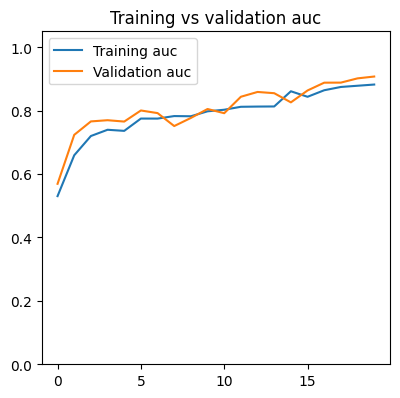

In [ ]:
graph(history9)

39/39 [==============================] - 19s 491ms/step


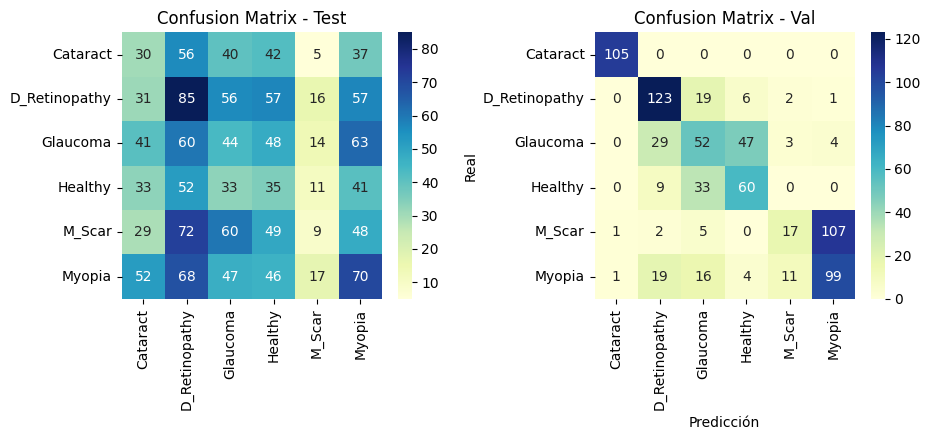

In [ ]:
y_pred9_test = model9.predict(test_generator)
y_pred9_val = model9.predict(validation_generator)
cf_matrix(y_pred9_test, test_generator.classes, y_pred9_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model9, y_pred9_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model9, y_pred9_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.22      0.28      0.24       302
           2       0.16      0.16      0.16       270
           3       0.13      0.17      0.15       205
           4       0.12      0.03      0.05       267
           5       0.22      0.23      0.23       300

    accuracy                           0.18      1554
   macro avg       0.16      0.17      0.16      1554
weighted avg       0.17      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.68      0.81      0.74       151
           2       0.42      0.39      0.40       135
           3       0.51      0.59      0.55       102
           4       0.52      0.13      0.21       132
           5       0.47      0.66      0.55       150

    accuracy                           0.59       775
   macro avg       0.60

## Modelo 2

In [ ]:
base_model2 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model2.layers:
    layer.trainable = False


model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(6, activation='softmax'))
model2.summary()

model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history2 = model2.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 512)               1049088   
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                      

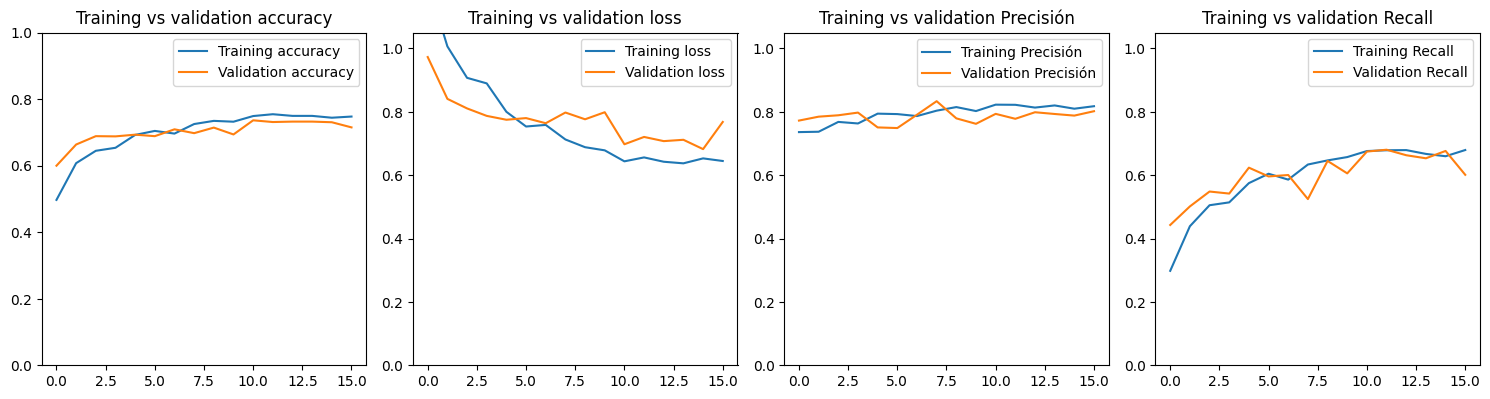

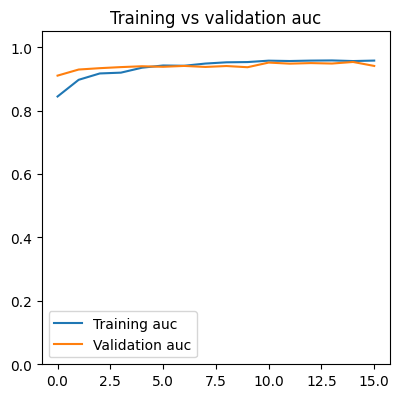

In [ ]:
graph(history2)

39/39 [==============================] - 15s 393ms/step


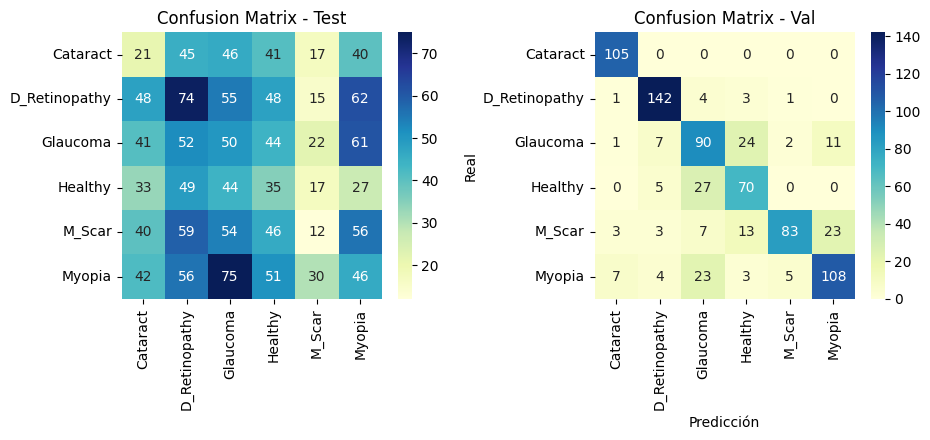

In [ ]:
y_pred2_test = model2.predict(test_generator)
y_pred2_val = model2.predict(validation_generator)
cf_matrix(y_pred2_test, test_generator.classes, y_pred2_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model2, y_pred2_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model2, y_pred2_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.09      0.10      0.10       210
           1       0.22      0.25      0.23       302
           2       0.15      0.19      0.17       270
           3       0.13      0.17      0.15       205
           4       0.11      0.04      0.06       267
           5       0.16      0.15      0.16       300

    accuracy                           0.15      1554
   macro avg       0.14      0.15      0.14      1554
weighted avg       0.15      0.15      0.15      1554

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       105
           1       0.88      0.94      0.91       151
           2       0.60      0.67      0.63       135
           3       0.62      0.69      0.65       102
           4       0.91      0.63      0.74       132
           5       0.76      0.72      0.74       150

    accuracy                           0.77       775
   macro avg       0.78

## Modelo 10

In [ ]:
base_model10 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model10.layers:
    layer.trainable = False


model10 = Sequential()
model10.add(base_model10)
model10.add(GlobalAveragePooling2D())
model10.add(Dense(2056, activation = 'leaky_relu'))
model10.add(Dense(1024, activation = 'leaky_relu'))
model10.add(Dense(512, activation = 'leaky_relu'))
model10.add(Dense(256, activation = 'leaky_relu'))
model10.add(Dense(6, activation='softmax'))
model10.summary()

model10.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history10 = model10.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 2056)              4212744   
                                                                 
 dense_31 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                      

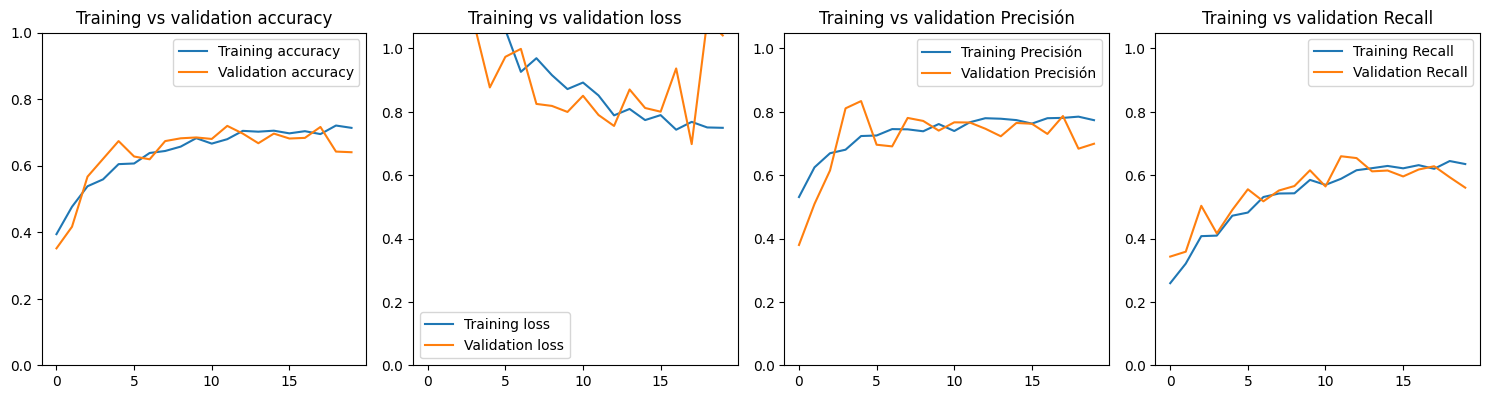

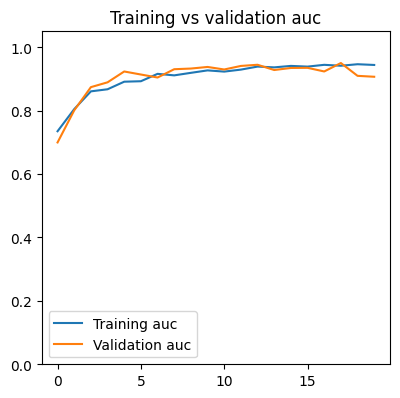

In [ ]:
graph(history10)

39/39 [==============================] - 16s 413ms/step


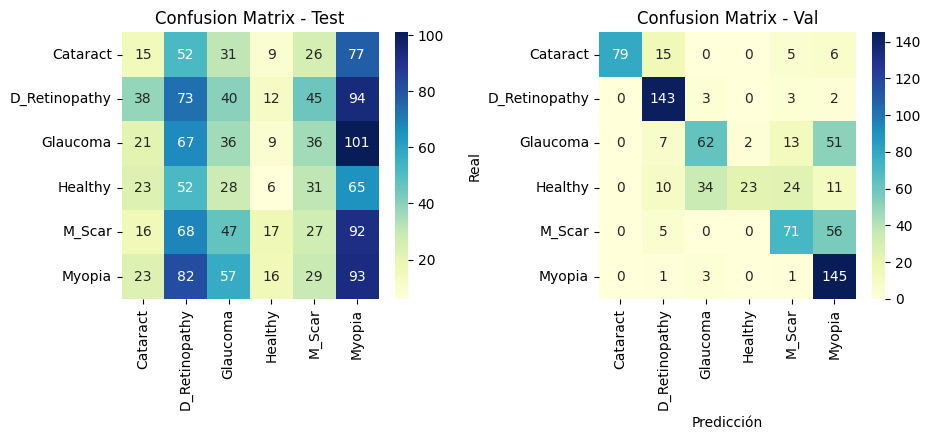

In [ ]:
y_pred10_test = model10.predict(test_generator)
y_pred10_val = model10.predict(validation_generator)
cf_matrix(y_pred10_test, test_generator.classes, y_pred10_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model10, y_pred10_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model10, y_pred10_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.07      0.09       210
           1       0.19      0.24      0.21       302
           2       0.15      0.13      0.14       270
           3       0.09      0.03      0.04       205
           4       0.14      0.10      0.12       267
           5       0.18      0.31      0.23       300

    accuracy                           0.16      1554
   macro avg       0.14      0.15      0.14      1554
weighted avg       0.15      0.16      0.15      1554

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       105
           1       0.79      0.95      0.86       151
           2       0.61      0.46      0.52       135
           3       0.92      0.23      0.36       102
           4       0.61      0.54      0.57       132
           5       0.54      0.97      0.69       150

    accuracy                           0.67       775
   macro avg       0.74

## Modelo 11

In [ ]:
base_model11 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model11.layers:
    layer.trainable = False


model11 = Sequential()
model11.add(base_model11)
model11.add(GlobalAveragePooling2D())
model11.add(Dense(2056, activation = 'relu'))
model11.add(Dense(1024, activation = 'relu'))
model11.add(Dense(512, activation = 'relu'))
model11.add(Dense(256, activation = 'relu'))
model11.add(Dense(6, activation='softmax'))
model11.summary()

model11.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history11 = model11.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2056)              4212744   
                                                                 
 dense_1 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               13

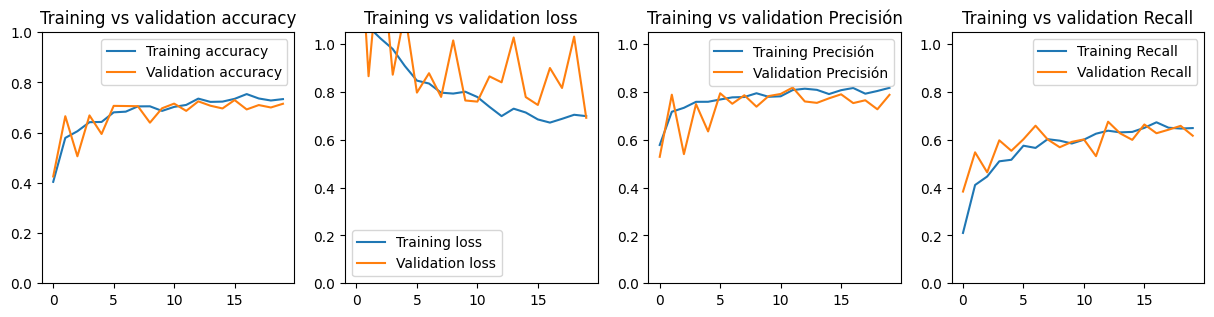

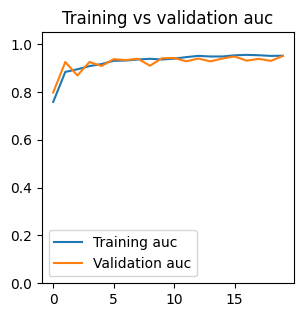

In [ ]:
graph(history11)

39/39 [==============================] - 16s 404ms/step


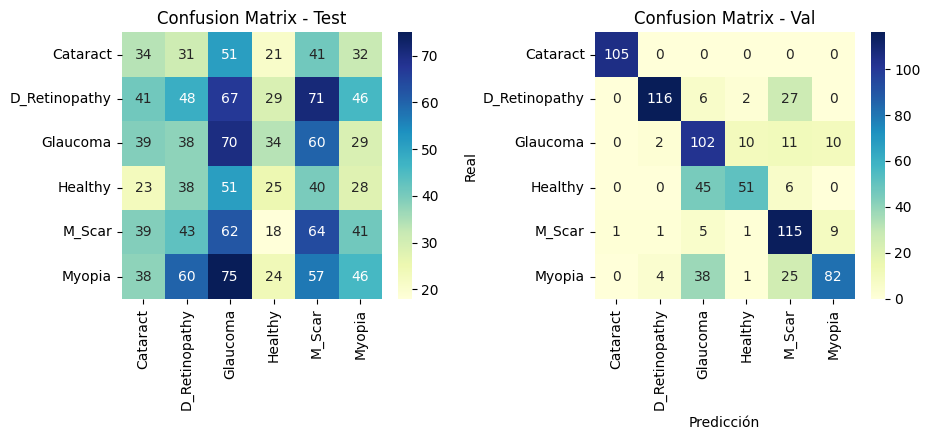

In [ ]:
y_pred11_test = model11.predict(test_generator)
y_pred11_val = model11.predict(validation_generator)
cf_matrix(y_pred11_test, test_generator.classes, y_pred11_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model11, y_pred11_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model11, y_pred11_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.19      0.16      0.17       302
           2       0.19      0.26      0.22       270
           3       0.17      0.12      0.14       205
           4       0.19      0.24      0.21       267
           5       0.21      0.15      0.18       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.94      0.77      0.85       151
           2       0.52      0.76      0.62       135
           3       0.78      0.50      0.61       102
           4       0.62      0.87      0.73       132
           5       0.81      0.55      0.65       150

    accuracy                           0.74       775
   macro avg       0.78

## Modelo 12

In [ ]:
base_model12 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model12.layers:
    layer.trainable = False


model12 = Sequential()
model12.add(base_model12)
model12.add(GlobalAveragePooling2D())
model12.add(Dense(2056, activation = 'relu'))
model12.add(Dense(1024, activation = 'relu'))
model12.add(Dense(512, activation = 'relu'))
model12.add(Dense(256, activation = 'relu'))
model12.add(Dense(6, activation='softmax'))
model12.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model12.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history12 = model12.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_6 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                      

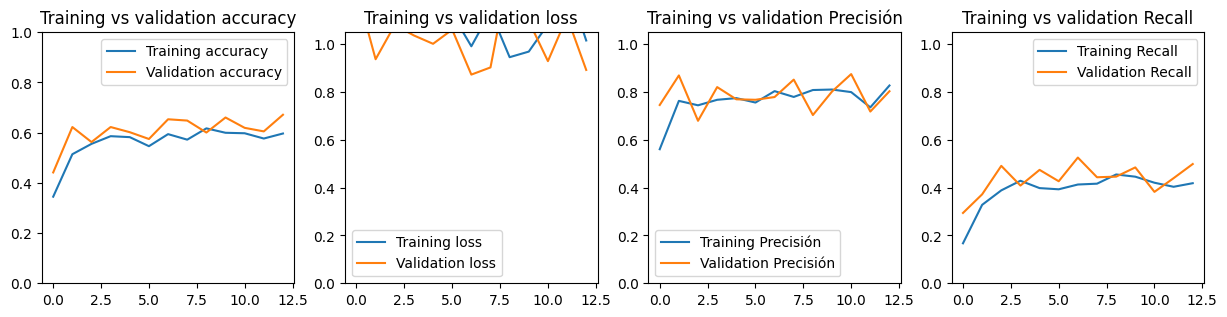

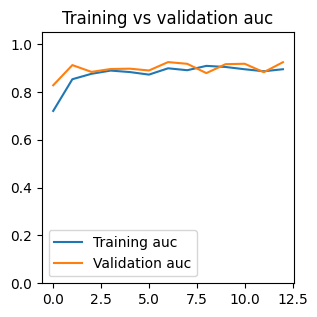

In [ ]:
graph(history12)

39/39 [==============================] - 15s 383ms/step


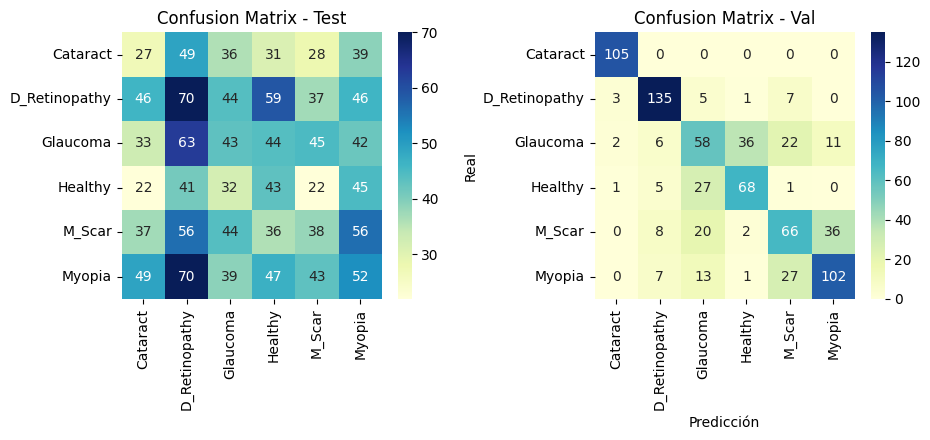

In [ ]:
y_pred12_test = model12.predict(test_generator)
y_pred12_val = model12.predict(validation_generator)
cf_matrix(y_pred12_test, test_generator.classes, y_pred12_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model12, y_pred12_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model12, y_pred12_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.20      0.23      0.22       302
           2       0.18      0.16      0.17       270
           3       0.17      0.21      0.18       205
           4       0.18      0.14      0.16       267
           5       0.19      0.17      0.18       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       105
           1       0.84      0.89      0.87       151
           2       0.47      0.43      0.45       135
           3       0.63      0.67      0.65       102
           4       0.54      0.50      0.52       132
           5       0.68      0.68      0.68       150

    accuracy                           0.69       775
   macro avg       0.68

## Modelo 20


In [19]:
# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

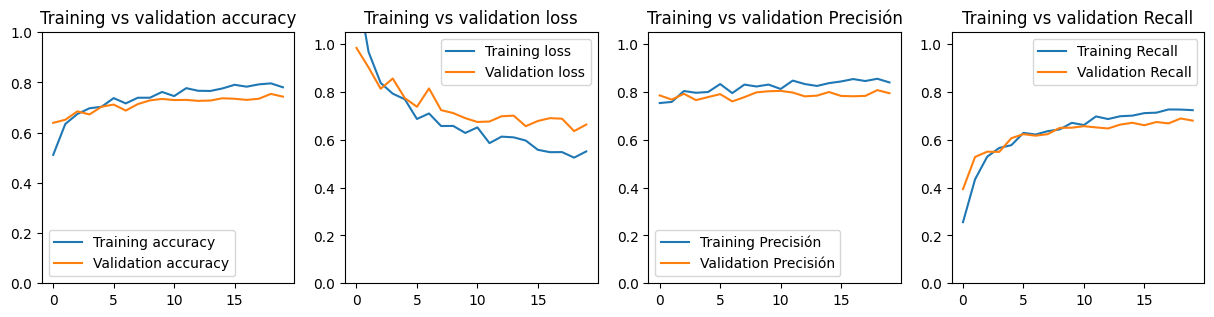

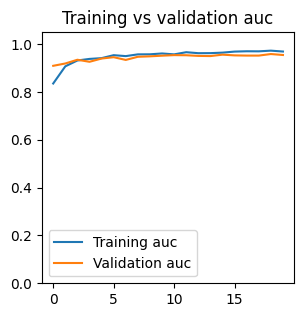

In [20]:
graph(history_dense)

39/39 [==============================] - 13s 343ms/step


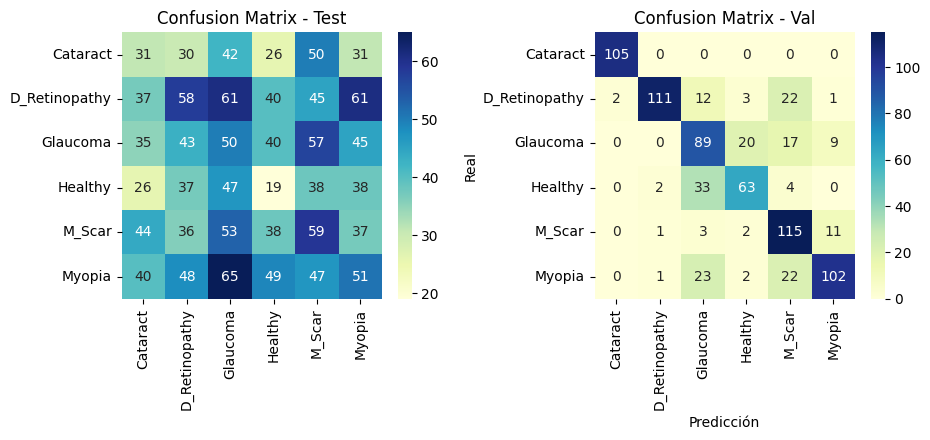

In [21]:
y_pred_test = model.predict(test_generator)
y_pred_val = model.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [24]:
reporte = calcular_metricas_por_clase(model, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.23      0.19      0.21       302
           2       0.16      0.19      0.17       270
           3       0.09      0.09      0.09       205
           4       0.20      0.22      0.21       267
           5       0.19      0.17      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.97      0.74      0.83       151
           2       0.56      0.66      0.60       135
           3       0.70      0.62      0.66       102
           4       0.64      0.87      0.74       132
           5       0.83      0.68      0.75       150

    accuracy                           0.75       775
   macro avg       0.78

## Modelo 19


In [20]:
# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

94668760/94668760 [==============================] - 3s 0us/step
Epoch 1/25
150/150 [==============================] - 98s 582ms/step - loss: 1.5105 - accuracy: 0.3730 - precision: 0.6784 - recall: 0.1153 - auc: 0.7402 - val_loss: 1.0638 - val_accuracy: 0.5882 - val_precision: 0.8239 - val_recall: 0.2799 - val_auc: 0.8941
Epoch 2/25
150/150 [==============================] - 87s 577ms/step - loss: 1.1984 - accuracy: 0.5137 - precision: 0.6962 - recall: 0.3178 - auc: 0.8496 - val_loss: 0.9608 - val_accuracy: 0.6229 - val_precision: 0.7756 - val_recall: 0.4337 - val_auc: 0.9074
Epoch 3/25
150/150 [==============================] - 85s 565ms/step - loss: 1.0713 - accuracy: 0.5783 - precision: 0.7318 - recall: 0.4047 - auc: 0.8820 - val_loss: 0.9220 - val_accuracy: 0.6377 - val_precision: 0.7407 - val_recall: 0.5000 - val_auc: 0.9145
Epoch 4/25
150/150 [==============================] - 85s 568ms/step - loss: 1.0216 - accuracy: 0.5869 - precision: 0.7325 - recall: 0.4238 - auc: 0.8927 - va

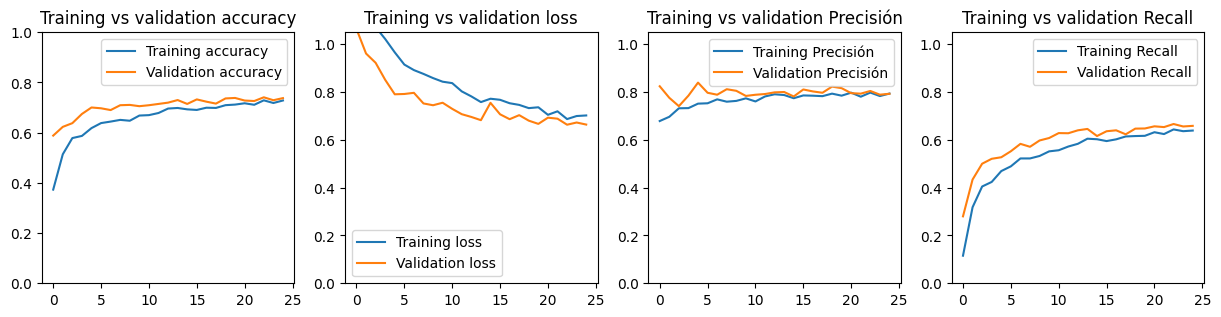

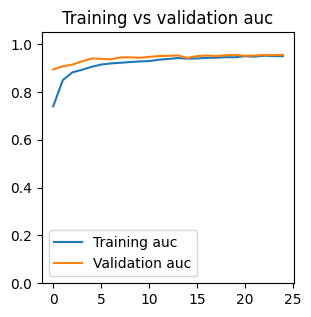

In [21]:
graph(history19)

39/39 [==============================] - 12s 323ms/step


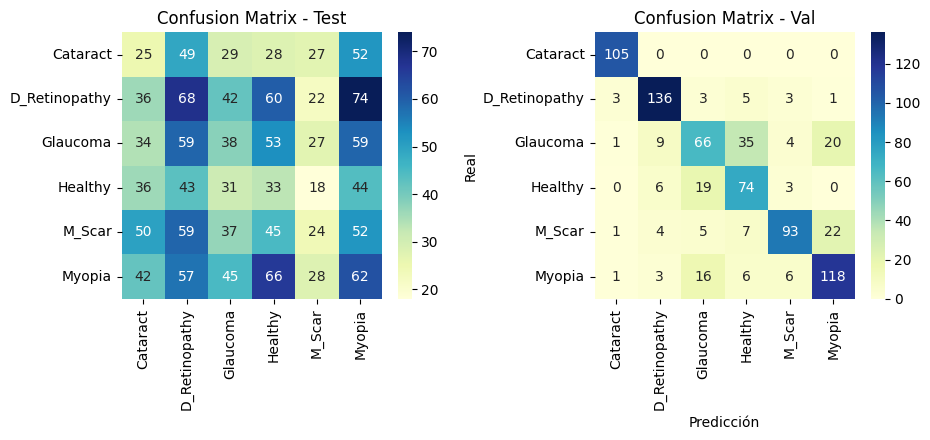

In [22]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [23]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.12      0.12       210
           1       0.20      0.23      0.21       302
           2       0.17      0.14      0.15       270
           3       0.12      0.16      0.13       205
           4       0.16      0.09      0.12       267
           5       0.18      0.21      0.19       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       105
           1       0.86      0.90      0.88       151
           2       0.61      0.49      0.54       135
           3       0.58      0.73      0.65       102
           4       0.85      0.70      0.77       132
           5       0.73      0.79      0.76       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo v50

In [ ]:
base_modelv50 = tf.keras.applications.ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_modelv50.layers:
    layer.trainable = False


modelv50 = Sequential()
modelv50.add(base_modelv50)
modelv50.add(GlobalAveragePooling2D())
modelv50.add(Dense(2056, activation = 'relu'))
modelv50.add(Dense(1024, activation = 'relu'))
modelv50.add(Dense(512, activation = 'relu'))
modelv50.add(Dense(256, activation = 'relu'))
modelv50.add(Dense(6, activation='softmax'))
modelv50.summary()

modelv50.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

historyv50 = modelv50.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 2056)              4212744   
                                                                 
 dense_11 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 256)               

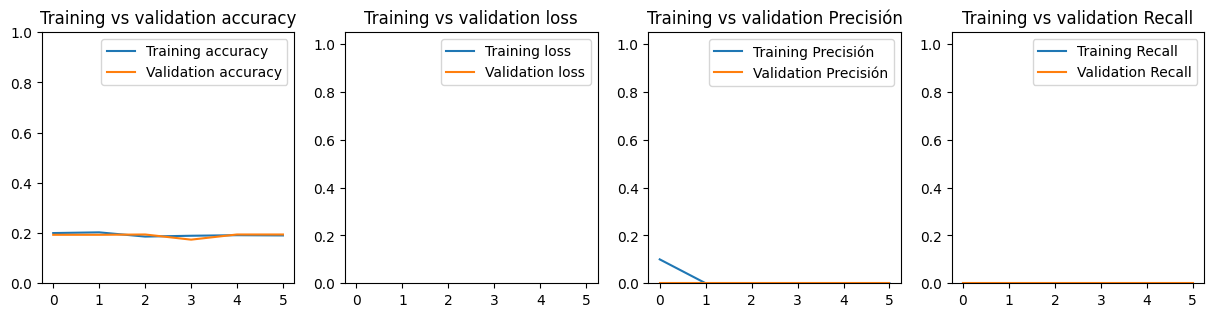

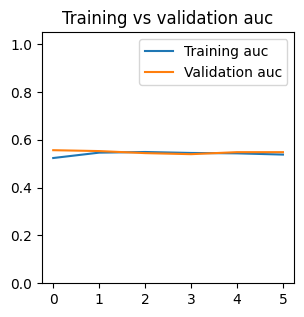

In [ ]:
graph(historyv50)

39/39 [==============================] - 17s 430ms/step


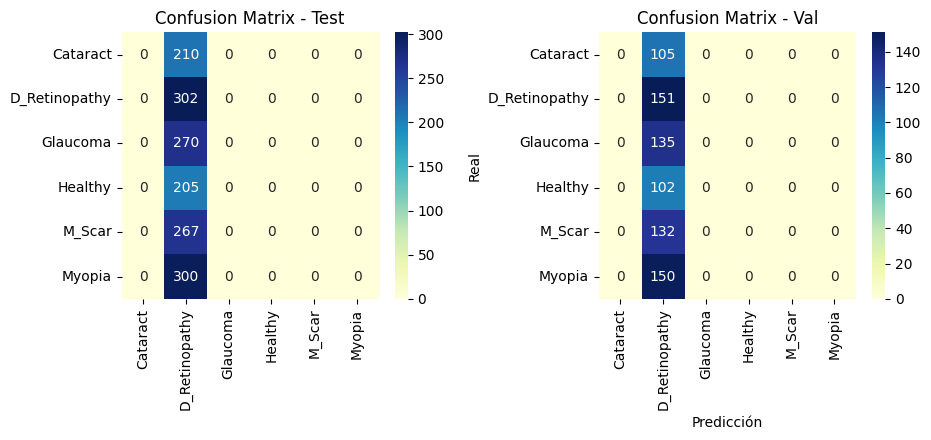

In [ ]:
y_predv50_test = modelv50.predict(test_generator)
y_predv50_val = modelv50.predict(validation_generator)
cf_matrix(y_predv50_test, test_generator.classes, y_predv50_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(modelv50, y_predv50_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(modelv50, y_predv50_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.19      1.00      0.33       302
           2       0.00      0.00      0.00       270
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00       267
           5       0.00      0.00      0.00       300

    accuracy                           0.19      1554
   macro avg       0.03      0.17      0.05      1554
weighted avg       0.04      0.19      0.06      1554

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.19      1.00      0.33       151
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00       132
           5       0.00      0.00      0.00       150

    accuracy                           0.19       775
   macro avg       0.03

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 148s 544ms/step - loss: 0.5508 - accuracy: 0.7745 - precision: 0.8309 - recall: 0.7145 - auc: 0.9687
Evaluar con Validación:
78/78 [==============================] - 30s 386ms/step - loss: 0.6316 - accuracy: 0.7548 - precision: 0.8049 - recall: 0.6931 - auc: 0.9589
Evaluar con Prueba:
39/39 [==============================] - 16s 410ms/step - loss: 0.5944 - accuracy: 0.7600 - precision: 0.7997 - recall: 0.7006 - auc: 0.9635


In [ ]:
evaluar_modelo(model4)

Evaluar con train:
272/272 [==============================] - 142s 523ms/step - loss: 0.4769 - accuracy: 0.8047 - precision: 0.8506 - recall: 0.7601 - auc: 0.9766
Evaluar con validation:
39/39 [==============================] - 12s 318ms/step - loss: 0.5551 - accuracy: 0.7613 - precision: 0.8055 - recall: 0.7213 - auc: 0.9681
Evaluar con test:
78/78 [==============================] - 26s 338ms/step - loss: 0.6453 - accuracy: 0.7535 - precision: 0.7831 - recall: 0.7085 - auc: 0.9583


In [ ]:
evaluar_modelo(model5)

Evaluar con train:
272/272 [==============================] - 153s 561ms/step - loss: 0.3929 - accuracy: 0.8415 - precision: 0.8746 - recall: 0.8052 - auc: 0.9838
Evaluar con validation:
39/39 [==============================] - 18s 471ms/step - loss: 0.5401 - accuracy: 0.7897 - precision: 0.8286 - recall: 0.7548 - auc: 0.9688
Evaluar con test:
78/78 [==============================] - 24s 308ms/step - loss: 0.6768 - accuracy: 0.7542 - precision: 0.7874 - recall: 0.7175 - auc: 0.9559


In [ ]:
evaluar_modelo(model15)

Evaluar con train:
272/272 [==============================] - 142s 523ms/step - loss: 0.3460 - accuracy: 0.8584 - precision: 0.8758 - recall: 0.8409 - auc: 0.9869
Evaluar con validation:
39/39 [==============================] - 13s 337ms/step - loss: 0.5848 - accuracy: 0.7794 - precision: 0.7970 - recall: 0.7600 - auc: 0.9671
Evaluar con test:
78/78 [==============================] - 26s 334ms/step - loss: 0.7168 - accuracy: 0.7580 - precision: 0.7773 - recall: 0.7387 - auc: 0.9544


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 150s 551ms/step - loss: 0.4443 - accuracy: 0.8225 - precision: 0.8544 - recall: 0.7894 - auc: 0.9796
Evaluar con Validación:
78/78 [==============================] - 28s 361ms/step - loss: 0.6678 - accuracy: 0.7432 - precision: 0.7844 - recall: 0.7117 - auc: 0.9565
Evaluar con Prueba:
39/39 [==============================] - 15s 394ms/step - loss: 0.5219 - accuracy: 0.7961 - precision: 0.8150 - recall: 0.7561 - auc: 0.9720


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 151s 555ms/step - loss: 0.4386 - accuracy: 0.8229 - precision: 0.8687 - recall: 0.7710 - auc: 0.9804
Evaluar con Validación:
78/78 [==============================] - 32s 409ms/step - loss: 0.7003 - accuracy: 0.7407 - precision: 0.7941 - recall: 0.6898 - auc: 0.9525
Evaluar con Prueba:
39/39 [==============================] - 16s 400ms/step - loss: 0.5728 - accuracy: 0.7626 - precision: 0.8127 - recall: 0.7110 - auc: 0.9665


In [ ]:
evaluar_modelo(model3)

Evaluar con Entrenamiento:
272/272 [==============================] - 149s 549ms/step - loss: 0.5645 - accuracy: 0.7765 - precision: 0.8158 - recall: 0.7281 - auc: 0.9668
Evaluar con Validación:
78/78 [==============================] - 31s 391ms/step - loss: 0.7375 - accuracy: 0.7297 - precision: 0.7610 - recall: 0.6905 - auc: 0.9465
Evaluar con Prueba:
39/39 [==============================] - 16s 399ms/step - loss: 0.6242 - accuracy: 0.7445 - precision: 0.7886 - recall: 0.7123 - auc: 0.9593


In [ ]:
evaluar_modelo(model7)

Evaluar con Entrenamiento:
272/272 [==============================] - 150s 549ms/step - loss: 0.6484 - accuracy: 0.7401 - precision: 0.8278 - recall: 0.6283 - auc: 0.9573
Evaluar con Validación:
78/78 [==============================] - 31s 390ms/step - loss: 0.6946 - accuracy: 0.7291 - precision: 0.8129 - recall: 0.6261 - auc: 0.9511
Evaluar con Prueba:
39/39 [==============================] - 15s 387ms/step - loss: 0.6159 - accuracy: 0.7548 - precision: 0.8352 - recall: 0.6735 - auc: 0.9617


In [ ]:
evaluar_modelo(model8)

Evaluar con Entrenamiento:
272/272 [==============================] - 154s 567ms/step - loss: 0.8847 - accuracy: 0.6427 - precision: 0.7798 - recall: 0.5090 - auc: 0.9209
Evaluar con Validación:
78/78 [==============================] - 30s 381ms/step - loss: 0.8748 - accuracy: 0.6377 - precision: 0.7539 - recall: 0.5302 - auc: 0.9239
Evaluar con Prueba:
39/39 [==============================] - 16s 418ms/step - loss: 0.8154 - accuracy: 0.6374 - precision: 0.7795 - recall: 0.5290 - auc: 0.9311


In [ ]:
evaluar_modelo(model9)

Evaluar con Entrenamiento:
272/272 [==============================] - 173s 635ms/step - loss: 0.9812 - accuracy: 0.5729 - precision: 0.7711 - recall: 0.3330 - auc: 0.8995
Evaluar con Validación:
78/78 [==============================] - 38s 479ms/step - loss: 0.9379 - accuracy: 0.5940 - precision: 0.7792 - recall: 0.3520 - auc: 0.9076
Evaluar con Prueba:
39/39 [==============================] - 20s 511ms/step - loss: 0.8567 - accuracy: 0.5884 - precision: 0.7132 - recall: 0.3626 - auc: 0.9221


In [ ]:
evaluar_modelo(model2)

Evaluar con Entrenamiento:
272/272 [==============================] - 157s 576ms/step - loss: 0.6214 - accuracy: 0.7616 - precision: 0.8737 - recall: 0.6353 - auc: 0.9633
Evaluar con Validación:
78/78 [==============================] - 31s 391ms/step - loss: 0.7678 - accuracy: 0.7149 - precision: 0.8017 - recall: 0.6010 - auc: 0.9411
Evaluar con Prueba:
39/39 [==============================] - 16s 419ms/step - loss: 0.6521 - accuracy: 0.7716 - precision: 0.8353 - recall: 0.6348 - auc: 0.9581


In [ ]:
evaluar_modelo(model10)

Evaluar con Entrenamiento:
272/272 [==============================] - 154s 565ms/step - loss: 1.1185 - accuracy: 0.6360 - precision: 0.7088 - recall: 0.5650 - auc: 0.9013
Evaluar con Validación:
78/78 [==============================] - 32s 405ms/step - loss: 1.0408 - accuracy: 0.6403 - precision: 0.6990 - recall: 0.5605 - auc: 0.9069
Evaluar con Prueba:
39/39 [==============================] - 16s 407ms/step - loss: 0.8672 - accuracy: 0.6748 - precision: 0.7349 - recall: 0.6116 - auc: 0.9287


In [ ]:
evaluar_modelo(model11)

Evaluar con Entrenamiento:
272/272 [==============================] - 149s 545ms/step - loss: 0.5890 - accuracy: 0.7493 - precision: 0.8291 - recall: 0.6467 - auc: 0.9651
Evaluar con Validación:
78/78 [==============================] - 30s 387ms/step - loss: 0.6920 - accuracy: 0.7149 - precision: 0.7880 - recall: 0.6171 - auc: 0.9505
Evaluar con Prueba:
39/39 [==============================] - 16s 409ms/step - loss: 0.6023 - accuracy: 0.7368 - precision: 0.8076 - recall: 0.6555 - auc: 0.9623


In [ ]:
evaluar_modelo(model12)

Evaluar con Entrenamiento:
272/272 [==============================] - 145s 531ms/step - loss: 0.8639 - accuracy: 0.6578 - precision: 0.8419 - recall: 0.4726 - auc: 0.9257
Evaluar con Validación:
78/78 [==============================] - 31s 394ms/step - loss: 0.8921 - accuracy: 0.6712 - precision: 0.8031 - recall: 0.4987 - auc: 0.9246
Evaluar con Prueba:
39/39 [==============================] - 15s 376ms/step - loss: 0.8017 - accuracy: 0.6890 - precision: 0.8304 - recall: 0.4865 - auc: 0.9375


In [24]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 118s 435ms/step - loss: 0.5944 - accuracy: 0.7577 - precision: 0.8375 - recall: 0.6672 - auc: 0.9652
Evaluar con Validación:
78/78 [==============================] - 20s 251ms/step - loss: 0.6637 - accuracy: 0.7375 - precision: 0.7924 - recall: 0.6583 - auc: 0.9550
Evaluar con Prueba:
39/39 [==============================] - 10s 262ms/step - loss: 0.5706 - accuracy: 0.7639 - precision: 0.8367 - recall: 0.6942 - auc: 0.9676


In [23]:
evaluar_modelo(model)

Evaluar con Entrenamiento:
272/272 [==============================] - 124s 454ms/step - loss: 0.5567 - accuracy: 0.7850 - precision: 0.8384 - recall: 0.7165 - auc: 0.9685
Evaluar con Validación:
78/78 [==============================] - 22s 277ms/step - loss: 0.6636 - accuracy: 0.7432 - precision: 0.7947 - recall: 0.6802 - auc: 0.9546
Evaluar con Prueba:
39/39 [==============================] - 11s 283ms/step - loss: 0.5995 - accuracy: 0.7548 - precision: 0.8097 - recall: 0.7084 - auc: 0.9630


In [ ]:
evaluar_modelo(modelv50)

Evaluar con Entrenamiento:
272/272 [==============================] - 155s 571ms/step - loss: 1.7804 - accuracy: 0.1944 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5486
Evaluar con Validación:
78/78 [==============================] - 34s 428ms/step - loss: 1.7805 - accuracy: 0.1943 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5483
Evaluar con Prueba:
39/39 [==============================] - 17s 442ms/step - loss: 1.7804 - accuracy: 0.1948 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5489
